# 1. Download and unzip data

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [14]:
# '''
# You are recommended to use torchvision.datasets.ImageFolder to load data into the Pytorch dataset.
# To employ ImageFolder, the images should be arranged into:

#   root: train/val/test
#     class_a
#       a1.png
#       a2.png
#       ...
#     class_b
#       b1.png
#       b2.png
#       ...

# Write your codes here to organize the original data and split the data into training/validation/test set.
# '''
import os
import pandas as pd
import shutil

directories = [
   './train/benign', './train/malignant', './val/benign', 
    './val/malignant', './test/benign', './test/malignant'
]
for directory in directories:
    os.makedirs(directory, exist_ok=True)

train_csv = pd.read_csv('./ISBI2016_ISIC_Part3_Training_GroundTruth.csv')
test_csv = pd.read_csv('./ISBI2016_ISIC_Part3_Test_GroundTruth.csv')

print(train_csv.columns)
print(test_csv.columns)

test_size = len(test_csv)

def stratified_split(df, test_ratio=0.2):
    labels = df.iloc[:, -1]
    unique_labels = labels.unique()
    
    train_dfs = []
    val_dfs = []
    
    for label in unique_labels:
        subset = df[labels == label]
        n_val = max(1, int(len(subset) * test_ratio))
        val_subset = subset.sample(n=n_val, random_state=42)
        train_subset = subset.drop(val_subset.index)
        
        train_dfs.append(train_subset)
        val_dfs.append(val_subset)
    
    return pd.concat(train_dfs), pd.concat(val_dfs)

train_data, valid_data = stratified_split(train_csv)


print(f"Train data size: {len(train_data)}\nVal data size: {len(valid_data)}\nTest data size: {test_size}")

def copy_files(dataframe, src_folder, dest_folder, class_mapping):
    counters = {label: 0 for label in class_mapping.values()}
    for idx, row in dataframe.iterrows():
        name, label = row.iloc[0], row.iloc[1]
        target_label = class_mapping.get(label, label)
        counters[target_label] += 1
        shutil.copy(f"{src_folder}/{name}.jpg", f"{dest_folder}/{target_label}/{name}.jpg")
    return counters

label_mapping_train = {'benign': 'benign', 'malignant': 'malignant'}
label_mapping_test = {0.0: 'benign', 1.0: 'malignant'}

# Copy training files
train_counts = copy_files(train_data, './ISBI2016_ISIC_Part3_Training_Data', './train', label_mapping_train)
# Copy validation files
val_counts = copy_files(valid_data, './ISBI2016_ISIC_Part3_Training_Data', './val', label_mapping_train)
# Copy test files
test_counts = copy_files(test_csv.iloc[: test_size], './ISBI2016_ISIC_Part3_Test_Data', './test', label_mapping_test)
print(f"Train classes: {train_counts}")
print(f"Val classes: {val_counts}")
print(f"Test classes: {test_counts}")





Index(['ISIC_0000000', 'benign'], dtype='object')
Index(['ISIC_0000003', '0.0'], dtype='object')
Train data size: 720
Val data size: 179
Test data size: 378
Train classes: {'benign': 581, 'malignant': 139}
Val classes: {'benign': 145, 'malignant': 34}
Test classes: {'benign': 303, 'malignant': 75}


# 3. Prepare data and build dataloaders

In [15]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train, root_val, root_test = './train', './val', './test' # -- write your codes here: the root path of training/validation/test set

train_transform = transforms.Compose([
    # -- write your codes here: data preprocessing and augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.35, contrast=0.2),
    transforms.Resize(size = [224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # -- write your codes here: data preprocessing
    transforms.Resize([224, 224]), 
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_train_test_set(batch_size):
    train_dataset = ImageFolder(root_train, transform=train_transform)
    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train, loader_val, loader_test

batch_size = 16
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

In [16]:
ImageFolder(root_train, transform = train_transform)

Dataset ImageFolder
    Number of datapoints: 720
    Root location: ./train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.65, 1.35), contrast=(0.8, 1.2), saturation=None, hue=None)
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# 4. Build the network

## Implement ResNet50

In [17]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # -- write your codes here
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, 
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.1)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        # -- write your codes here
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
        pass

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        ### stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        # -- write your codes here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        # x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        
        if self.use_fc:
            # x = F.relu(self.fc_add(x))
            # print("FC Used")
            x = self.fc_add(x)

        if self.use_dropout:
            # print("Dropout Used")
            x = self.dropout(x)

        return x
        pass

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout= 0.75)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Classification Model

In [18]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        ### apply a vision encoder (ResNet-50 will be applied here)
        self.encoder = encoder
        # -- write your codes here: add a classifier to project the visual features
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        # -- write your codes here:
        x = self.encoder(x)
        # x = torch.sigmoid(self.classifier(x)) 
        x = self.classifier(x)
        return x
        pass

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 1)

Using dropout.


### 5. Train and test your model

In [24]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 20
Threshold = 0.7
pos_weight = torch.tensor([581 / 139])
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight).cuda()# -- write your codes here
# criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), 
                           lr = 0.001, 
                           momentum = 0.8,
                           nesterov = True,
                           weight_decay = 1e-3) # -- write your codes here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience = 1)

best_val_auc = 0.0
best_val_acc = 0.0
train_accs = []
metrics = {
    'train_loss': [], 'train_acc': [], 'train_auc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': []
}

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    model.train()
    train_loss = 0.0
    running_correct = 0
    all_preds, all_labels = [], []

    for data in tqdm(loader_train):
        # -- write your codes here
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        probs = torch.sigmoid(outputs.squeeze().detach()).cpu().numpy()
        running_correct += torch.sum(pred == labels)
        all_preds.extend(probs)
        all_labels.extend(labels.cpu().numpy())
    ### record the training loss and metrics
    # -- write your codes here
    train_loss = train_loss / len(loader_train.dataset)
    train_auc = roc_auc_score(all_labels, all_preds)
    train_accs.append(running_correct / len(loader_train.dataset))
    train_acc = accuracy_score(all_labels, (np.array(all_preds) > Threshold).astype(int))
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
    
    ### evaluate on validation set
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []
    
    with torch.no_grad():
        for data in loader_val:
            # -- write your codes here
            inputs, labels = data
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
                
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            
            val_loss += loss.item() 
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    ### record the validation loss and metrics, save the best checkpoint
    # -- write your codes here
    val_loss = val_loss / len(loader_val.dataset)
    val_auc = roc_auc_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, (np.array(val_preds) > Threshold).astype(int))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
    scheduler.step(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print("Current learning rate: {:.6f}".format(current_lr))

    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['train_auc'].append(train_auc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['val_auc'].append(val_auc)

### evaluate on test set
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint)
model.eval()
test_preds, test_labels = [], []

for data in loader_test:
    # -- write your codes here
    inputs, labels = data
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
        
    outputs = model(inputs).squeeze()
    test_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())

    test_labels.extend(labels.cpu().numpy())

### compute and print the metrics on test set
# -- write your codes here
test_auc = roc_auc_score(test_labels, test_preds)
test_acc = accuracy_score(test_labels, (np.array(test_preds) > Threshold).astype(int))
print(f"\nFinal Test Results - Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")


 -- Epoch 1/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.51s/it]


Train Loss: 0.0702 | Acc: 0.8069 | AUC: 0.5197
Current learning rate: 0.001000
Val Loss: 0.0818 | Acc: 0.8101 | AUC: 0.5836
 -- Epoch 2/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:08<00:00,  1.51s/it]


Train Loss: 0.0697 | Acc: 0.8069 | AUC: 0.5474
Current learning rate: 0.001000
Val Loss: 0.0820 | Acc: 0.8101 | AUC: 0.5708
 -- Epoch 3/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:10<00:00,  1.57s/it]


Train Loss: 0.0688 | Acc: 0.8069 | AUC: 0.5857
Current learning rate: 0.000800
Val Loss: 0.0818 | Acc: 0.8101 | AUC: 0.5838
 -- Epoch 4/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:08<00:00,  1.52s/it]


Train Loss: 0.0683 | Acc: 0.8069 | AUC: 0.6036
Current learning rate: 0.000800
Val Loss: 0.0818 | Acc: 0.8101 | AUC: 0.5966
 -- Epoch 5/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.50s/it]


Train Loss: 0.0687 | Acc: 0.8069 | AUC: 0.5969
Current learning rate: 0.000800
Val Loss: 0.0815 | Acc: 0.8101 | AUC: 0.6333
 -- Epoch 6/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:09<00:00,  1.53s/it]


Train Loss: 0.0690 | Acc: 0.8069 | AUC: 0.5970
Current learning rate: 0.000800
Val Loss: 0.0808 | Acc: 0.8101 | AUC: 0.6746
 -- Epoch 7/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.50s/it]


Train Loss: 0.0691 | Acc: 0.8069 | AUC: 0.5707
Current learning rate: 0.000800
Val Loss: 0.0810 | Acc: 0.8101 | AUC: 0.6501
 -- Epoch 8/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.0683 | Acc: 0.8069 | AUC: 0.6145
Current learning rate: 0.000800
Val Loss: 0.0801 | Acc: 0.8101 | AUC: 0.6868
 -- Epoch 9/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.49s/it]


Train Loss: 0.0691 | Acc: 0.8069 | AUC: 0.5807
Current learning rate: 0.000800
Val Loss: 0.0800 | Acc: 0.8101 | AUC: 0.6939
 -- Epoch 10/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.0666 | Acc: 0.8069 | AUC: 0.6892
Current learning rate: 0.000800
Val Loss: 0.0802 | Acc: 0.8101 | AUC: 0.6919
 -- Epoch 11/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.0677 | Acc: 0.8069 | AUC: 0.6326
Current learning rate: 0.000800
Val Loss: 0.0800 | Acc: 0.8101 | AUC: 0.6789
 -- Epoch 12/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.47s/it]


Train Loss: 0.0677 | Acc: 0.8069 | AUC: 0.6530
Current learning rate: 0.000800
Val Loss: 0.0801 | Acc: 0.8101 | AUC: 0.6822
 -- Epoch 13/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.50s/it]


Train Loss: 0.0685 | Acc: 0.8069 | AUC: 0.6061
Current learning rate: 0.000800
Val Loss: 0.0796 | Acc: 0.8101 | AUC: 0.7166
 -- Epoch 14/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.49s/it]


Train Loss: 0.0681 | Acc: 0.8069 | AUC: 0.6228
Current learning rate: 0.000800
Val Loss: 0.0794 | Acc: 0.8101 | AUC: 0.7247
 -- Epoch 15/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.49s/it]


Train Loss: 0.0676 | Acc: 0.8069 | AUC: 0.6418
Current learning rate: 0.000800
Val Loss: 0.0797 | Acc: 0.8101 | AUC: 0.7233
 -- Epoch 16/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:07<00:00,  1.51s/it]


Train Loss: 0.0664 | Acc: 0.8069 | AUC: 0.6789
Current learning rate: 0.000800
Val Loss: 0.0793 | Acc: 0.8101 | AUC: 0.7245
 -- Epoch 17/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.0669 | Acc: 0.8069 | AUC: 0.6575
Current learning rate: 0.000800
Val Loss: 0.0789 | Acc: 0.8101 | AUC: 0.7316
 -- Epoch 18/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.47s/it]


Train Loss: 0.0671 | Acc: 0.8069 | AUC: 0.6640
Current learning rate: 0.000800
Val Loss: 0.0790 | Acc: 0.8101 | AUC: 0.7280
 -- Epoch 19/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:05<00:00,  1.46s/it]


Train Loss: 0.0657 | Acc: 0.8069 | AUC: 0.7087
Current learning rate: 0.000800
Val Loss: 0.0786 | Acc: 0.8101 | AUC: 0.7347
 -- Epoch 20/20


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.0661 | Acc: 0.8069 | AUC: 0.6938
Current learning rate: 0.000800
Val Loss: 0.0787 | Acc: 0.8101 | AUC: 0.7278

Final Test Results - Acc: 0.8016 | AUC: 0.6255


Precision: 0.0000
Recall: 0.0000
Specificity: 1.0000
Negative Predictive Value: 0.8016


C:\Users\Winter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


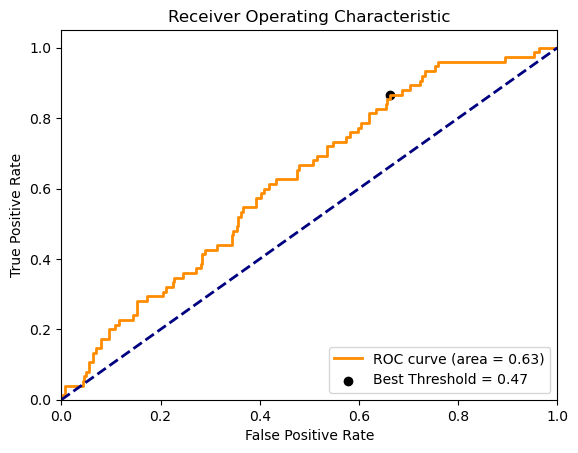

Best Threshold = 0.47


In [25]:
### plot your training and test curves
import matplotlib.pyplot as plt
# print(test_preds)

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve
test_precision = precision_score(test_labels, (np.array(test_preds) > Threshold).astype(int))
print(f'Precision: {test_precision:.4f}')
test_recall = recall_score(test_labels, (np.array(test_preds) > Threshold).astype(int))
print(f'Recall: {test_recall:.4f}')
test_cm = confusion_matrix(test_labels, (np.array(test_preds) > Threshold).astype(int))
tn, fp, fn, tp = test_cm.ravel()
test_specificity = tn / (tn + fp)
print(f'Specificity: {test_specificity:.4f}')
test_npv = tn / (tn + fn)
print(f'Negative Predictive Value: {test_npv:.4f}')

fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
# print(roc_auc = auc(fpr, tpr))

J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold = {:.2f}'.format(best_threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Best Threshold = {:.2f}".format(best_threshold))
      

[0.07018241708477338, 0.06967643019225862, 0.06884764043821229, 0.06830236150158776, 0.0687271268831359, 0.06898209212554826, 0.06906168791982863, 0.06828726637694571, 0.06905075858036677, 0.06657930223478212, 0.06774161408344904, 0.06774257140027153, 0.068491823060645, 0.06813550649417771, 0.0676288595630063, 0.06642723141445053, 0.0669108472764492, 0.06714618040455712, 0.06571497892340024, 0.06609781649377611]
[0.08177511385699224, 0.0820276966974056, 0.08184905058844795, 0.08176224757839182, 0.0814519794293622, 0.08077792248912363, 0.08097002692728736, 0.08007653432185423, 0.08003851421718491, 0.0802476232944254, 0.08002366500193846, 0.08005663669309136, 0.07956626228780053, 0.07942243677943779, 0.07968092614046023, 0.07925448920473706, 0.07889917426269148, 0.07895253457170626, 0.07855968235591271, 0.07873537587053948]


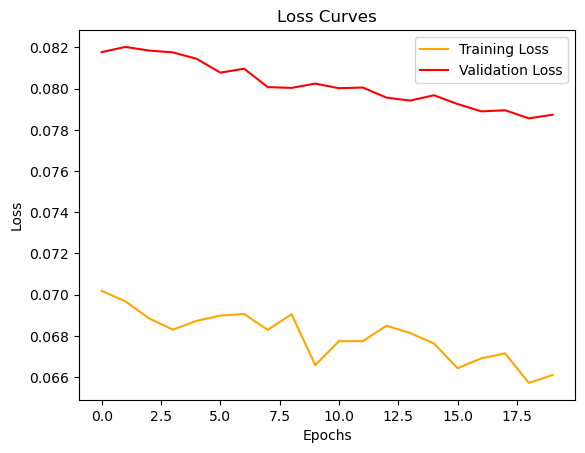

In [26]:
# print((np.array(test_preds) > 0.3).astype(int))
plt.figure()

# Loss Curves

plt.plot(metrics['train_loss'], color='orange', label='Training Loss')
plt.plot(metrics['val_loss'], color = 'red', label='Validation Loss')
print(metrics['train_loss'])
print(metrics['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

[0.5196572518233262, 0.5474188635322379, 0.5856994266892853, 0.6035735955125745, 0.596862269220768, 0.5970356245124383, 0.5707227677410567, 0.6144578313253013, 0.5806906970120977, 0.6891987270768584, 0.6325982243465124, 0.6529550885969365, 0.6060500996792928, 0.6228160328879753, 0.6418355848883716, 0.6788840872224767, 0.6574747087011974, 0.6639507670971657, 0.7086640498272639, 0.6938297898686215]
[0.5835699797160243, 0.5707910750507099, 0.5837728194726166, 0.596551724137931, 0.6332657200811359, 0.6746450304259635, 0.6501014198782962, 0.686815415821501, 0.6939148073022312, 0.6918864097363083, 0.6789046653144016, 0.6821501014198783, 0.7166328600405679, 0.7247464503042597, 0.7233265720081135, 0.7245436105476674, 0.7316430020283975, 0.7279918864097363, 0.7346855983772819, 0.7277890466531439]


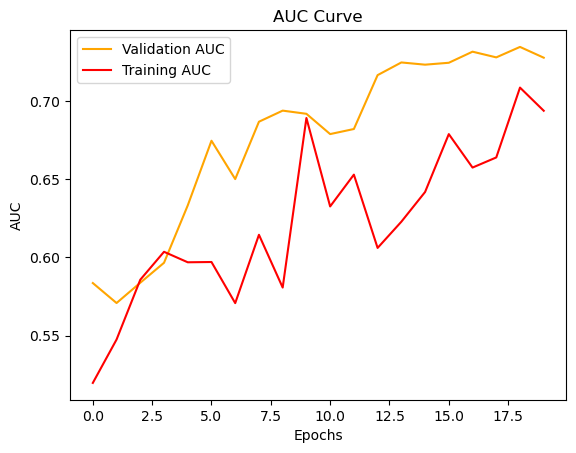

In [27]:
# AUC Curve
plt.plot(metrics['val_auc'], color='orange', label='Validation AUC')
plt.plot(metrics['train_auc'], color='red', label='Training AUC')
print(metrics['train_auc'])
print(metrics['val_auc'])
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()

[0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445, 0.8069444444444445]
[tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tensor(0.8069, device='cuda:0'), tens

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

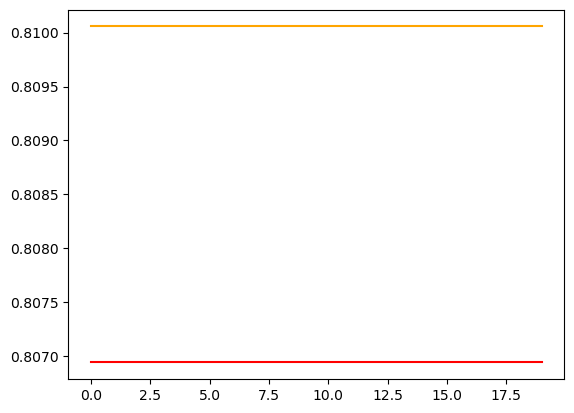

In [28]:
# ACC Curve
print(metrics['train_acc'])
print(train_accs)
print(metrics['val_acc'])
plt.plot(metrics['val_acc'], color='orange', label='Validation ACC')
plt.plot(metrics['train_acc'], color='red', label='Training ACC')
plt.plot(train_accs, color='blue', label='Training ACCs')


plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.title('ACC Curve')
plt.legend()